# Detect Retina Damage From OCT Images With CNN
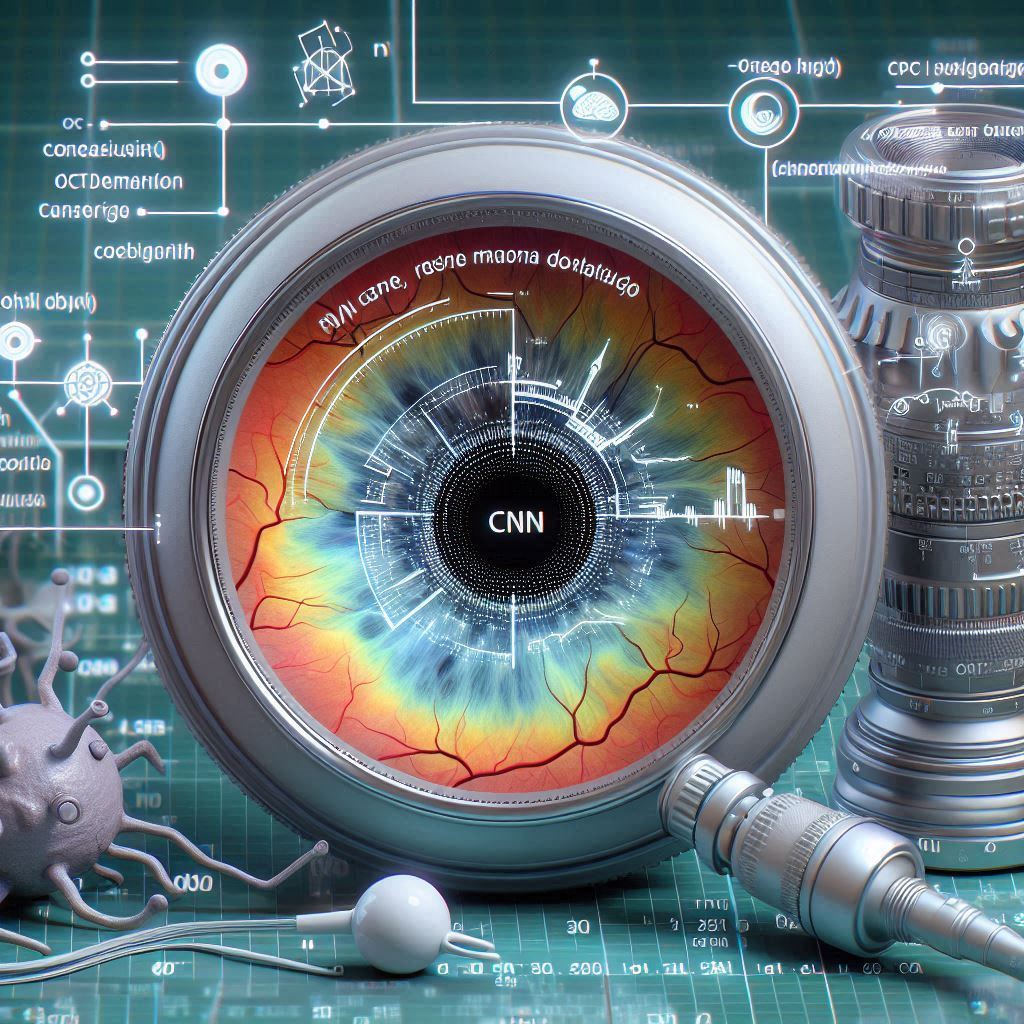

# Import Libraries

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

## Introduction

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images take up a significant amount of time (Swanson and Fujimoto, 2017).

Figure 2. Representative Optical Coherence Tomography Images and the Workflow Diagram [Kermany et al., 2018] http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

(A) (Far left) Choroidal neovascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL, CNV, DME, DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL, CNV, DME, DRUSEN).

Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

CNV (Choroidal Neovascularization): Choroidal neovascularization refers to the abnormal growth of new blood vessels beneath the retina. This condition is typically associated with diseases like age-related macular degeneration.

DME (Diabetic Macular Edema): Diabetic macular edema is the accumulation of fluid in the macula region of the retina due to diabetic retinopathy. It can lead to vision loss.

DRUSEN: Drusen are small yellowish or whitish deposits seen on the retina. They are considered early signs of diseases like age-related macular degeneration (AMD).

NORMAL: Normal retina images represent healthy retinal cross-sections without any pathological signs or abnormalities.

These terms play a significant role in the diagnosis and monitoring of retinal diseases in medical studies utilizing optical coherence tomography (OCT) imaging technology.


In [3]:
# Main Folder Path
folder_path = "/kaggle/input/kermany2018/OCT2017 "

# Sub Folder Paths
train_dir = f"{folder_path}/train"
val_dir = f"{folder_path}/val"
test_dir = f"{folder_path}/test"

In [4]:
os.listdir(folder_path)

['val', 'test', 'train']

In [5]:
print(f"Train Directory: {os.listdir(train_dir)}")
print(f"Validation Directory: {os.listdir(test_dir)}")
print(f"Test Directory: {os.listdir(val_dir)}")

Train Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Validation Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Test Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [6]:
normal_train_dir = os.path.join(train_dir, "NORMAL")
normal_train_files = os.listdir(normal_train_dir)[:30]

normal_train_files

['NORMAL-2348959-1.jpeg',
 'NORMAL-6581418-5.jpeg',
 'NORMAL-4969570-7.jpeg',
 'NORMAL-8027454-24.jpeg',
 'NORMAL-4034545-3.jpeg',
 'NORMAL-4949902-8.jpeg',
 'NORMAL-5587871-6.jpeg',
 'NORMAL-1149596-1.jpeg',
 'NORMAL-4670089-8.jpeg',
 'NORMAL-5628931-6.jpeg',
 'NORMAL-7984958-6.jpeg',
 'NORMAL-6580495-13.jpeg',
 'NORMAL-4538057-20.jpeg',
 'NORMAL-867217-3.jpeg',
 'NORMAL-9546378-10.jpeg',
 'NORMAL-9453622-6.jpeg',
 'NORMAL-3863241-1.jpeg',
 'NORMAL-8869683-18.jpeg',
 'NORMAL-114740-1.jpeg',
 'NORMAL-2483932-5.jpeg',
 'NORMAL-5535997-2.jpeg',
 'NORMAL-450923-19.jpeg',
 'NORMAL-66861-2.jpeg',
 'NORMAL-33350-20.jpeg',
 'NORMAL-519372-3.jpeg',
 'NORMAL-452201-5.jpeg',
 'NORMAL-9305707-5.jpeg',
 'NORMAL-3049062-6.jpeg',
 'NORMAL-9409941-4.jpeg',
 'NORMAL-2105194-36.jpeg']

In [7]:
normal_train_files[17]

'NORMAL-8869683-18.jpeg'

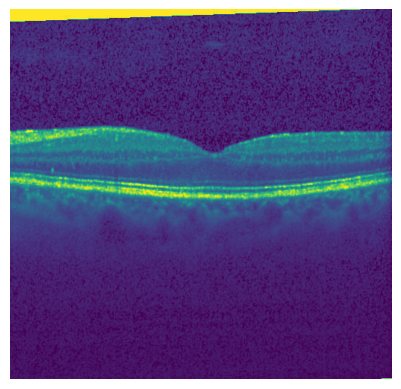

In [8]:
# Image file path
image_file = "NORMAL/NORMAL-8869683-18.jpeg"
image_path = os.path.join(train_dir, image_file)

# Read and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

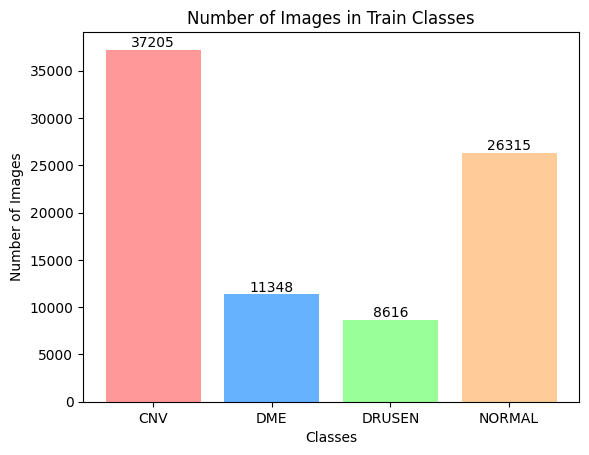

In [19]:
# Specify the directory where the dataset is located
dataset_directory = train_dir

# Create a dictionary to store the counts of images for each class
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

# Iterate through the dataset to count the number of images for each class
for class_name in image_counts.keys():
    class_directory = os.path.join(dataset_directory, class_name)
    image_counts[class_name] = len(os.listdir(class_directory))

# Plotting the graph
classes = list(image_counts.keys())
counts = list(image_counts.values())

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])

# Display total counts above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train Classes')
plt.show()

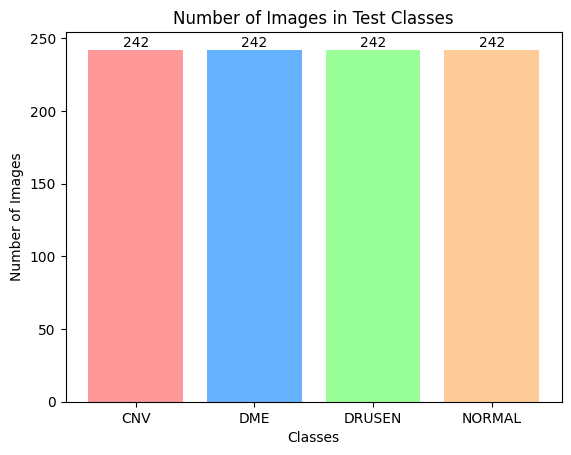

In [20]:

# Specify the directory where the dataset is located
dataset_directory = test_dir

# Create a dictionary to store the counts of images for each class
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

# Iterate through the dataset to count the number of images for each class
for class_name in image_counts.keys():
    class_directory = os.path.join(dataset_directory, class_name)
    image_counts[class_name] = len(os.listdir(class_directory))

# Plotting the graph
classes = list(image_counts.keys())
counts = list(image_counts.values())

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])

# Display total counts above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Test Classes')
plt.show()

In [21]:
# Specify the directory where the dataset is located
dataset_directory = train_dir

# Specify the classes
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Loop to return the shape of an image from each class
for class_name in classes:
    # Create the class directory
    class_directory = os.path.join(dataset_directory, class_name)

    # Select an image in the class directory
    image = os.listdir(class_directory)[55]

    # Load the image
    image_path = os.path.join(class_directory, image)
    image = cv2.imread(image_path)

    # Print the shape of the image
    print(f"Class: {class_name}, Image Shape: {image.shape}")

Class: CNV, Image Shape: (496, 768, 3)
Class: DME, Image Shape: (512, 512, 3)
Class: DRUSEN, Image Shape: (496, 1536, 3)
Class: NORMAL, Image Shape: (512, 512, 3)


In [23]:
# Specify the directory where the dataset is located
dataset_directory = train_dir

# Specify the classes
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Loop to return the shape of an image from each class
for class_name in classes:
    # Create the class directory
    class_directory = os.path.join(dataset_directory, class_name)

    # Select an image in the class directory
    image = os.listdir(class_directory)[55]

    # Load the image
    image_path = os.path.join(class_directory, image)
    image = cv2.imread(image_path)

    # Print the shape of the image
    print(f"Class: {class_name}, Image Shape: {image.shape}")

    x= []
    y = []

    img = image
    d1,d2,colors = img.shape
    x.append(d1)
    y.append(d2)

print(np.mean(x))
print(np.mean(y))



Class: CNV, Image Shape: (496, 768, 3)
Class: DME, Image Shape: (512, 512, 3)
Class: DRUSEN, Image Shape: (496, 1536, 3)
Class: NORMAL, Image Shape: (512, 512, 3)
512.0
512.0


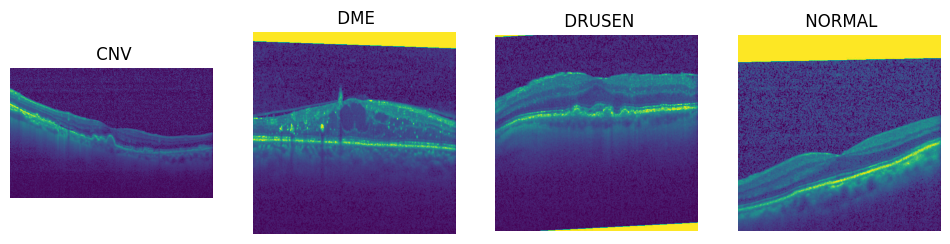

In [26]:

# Specify the classes
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Create a Matplotlib figure and axes
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# Load and display one example from each class side by side
for i, class_name in enumerate(classes):
    image_path = os.path.join(train_dir, class_name, os.listdir(os.path.join(train_dir, class_name))[0])
    img = imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f" {class_name}")

plt.show()

# Model 1

## Creating the Model

In [29]:
batch_size = 32

In [30]:
image_shape = (299,299,1)

In [31]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.20, # Shift the pic width by a max of 20%
                               height_shift_range=0.15, # Shift the pic height by a max of 15%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 15%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [33]:
image_gen.flow_from_directory(train_dir)

Found 83484 images belonging to 4 classes.


In [34]:
image_gen.flow_from_directory(test_dir)

Found 968 images belonging to 4 classes.


In [37]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(4, activation='softmax'))


In [38]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 299, 299, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 74, 74, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,682,244 (21.68 MB)

 Trainable params: 5,682,244 (21.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [42]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=True)

Found 83484 images belonging to 4 classes.


In [43]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 968 images belonging to 4 classes.


In [44]:
results = model.fit(train_image_gen,epochs=10, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/10
   1/2609 ━━━━━━━━━━━━━━━━━━━━ 18:26:28 25s/step - accuracy: 0.4688 - loss: 1.3737

I0000 00:00:1718978288.674112     353 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718978288.691802     353 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6401 - loss: 0.9186

W0000 00:00:1718979759.254395     353 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1514s 571ms/step - accuracy: 0.6401 - loss: 0.9186 - val_accuracy: 0.5651 - val_loss: 0.9273
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 782s 299ms/step - accuracy: 0.7523 - loss: 0.6556 - val_accuracy: 0.7180 - val_loss: 0.6585
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 792s 303ms/step - accuracy: 0.7961 - loss: 0.5534 - val_accuracy: 0.7335 - val_loss: 0.6304
Epoch 4/10
1401/2609 ━━━━━━━━━━━━━━━━━━━━ 5:57 296ms/step - accuracy: 0.8192 - loss: 0.4884

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2609/2609 ━━━━━━━━━━━━━━━━━━━━ 801s 306ms/step - accuracy: 0.8772 - loss: 0.3433 - val_accuracy: 0.9442 - val_loss: 0.1773
Epoch 10/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 780s 298ms/step - accuracy: 0.8845 - loss: 0.3250 - val_accuracy: 0.9473 - val_loss: 0.1724


In [45]:
summary = pd.DataFrame(model.history.history)
summary.head()

,accuracy,loss,val_accuracy,val_loss
0,0.705045,0.775693,0.565083,0.927310
1,0.763655,0.628844,0.717975,0.658545
2,0.802633,0.534489,0.733471,0.630418
3,0.826398,0.471872,0.804752,0.478903
4,0.844198,0.430579,0.895661,0.309139


In [46]:
model.history.history

{'accuracy': [0.7050452828407288,
  0.7636553049087524,
  0.8026328682899475,
  0.8263978958129883,
  0.844197690486908,
  0.8559843897819519,
  0.8670523762702942,
  0.8736764192581177,
  0.879905104637146,
  0.885187566280365],
 'loss': [0.7756932973861694,
  0.6288437843322754,
  0.5344889760017395,
  0.4718720316886902,
  0.43057870864868164,
  0.39840012788772583,
  0.3719087541103363,
  0.35526567697525024,
  0.33884307742118835,
  0.3240663409233093],
 'val_accuracy': [0.5650826692581177,
  0.7179751992225647,
  0.7334710955619812,
  0.8047520518302917,
  0.8956611752510071,
  0.9163222908973694,
  0.9266529083251953,
  0.9318181872367859,
  0.9442148804664612,
  0.9473140239715576],
 'val_loss': [0.9273096919059753,
  0.6585454344749451,
  0.6304177045822144,
  0.4789029061794281,
  0.3091391324996948,
  0.2875312566757202,
  0.22672772407531738,
  0.2097809761762619,
  0.1773107647895813,
  0.17235787212848663]}

In [47]:
history_df = pd.DataFrame(model.history.history)
history_df.index.name = 'Epoch'
history_df.index += 1  # Epoch numaralarını 1'den başlat

# DataFrame'i yazdır
print(history_df)

       accuracy      loss  val_accuracy  val_loss
Epoch                                            
1      0.705045  0.775693      0.565083  0.927310
2      0.763655  0.628844      0.717975  0.658545
3      0.802633  0.534489      0.733471  0.630418
4      0.826398  0.471872      0.804752  0.478903
5      0.844198  0.430579      0.895661  0.309139
6      0.855984  0.398400      0.916322  0.287531
7      0.867052  0.371909      0.926653  0.226728
8      0.873676  0.355266      0.931818  0.209781
9      0.879905  0.338843      0.944215  0.177311
10     0.885188  0.324066      0.947314  0.172358


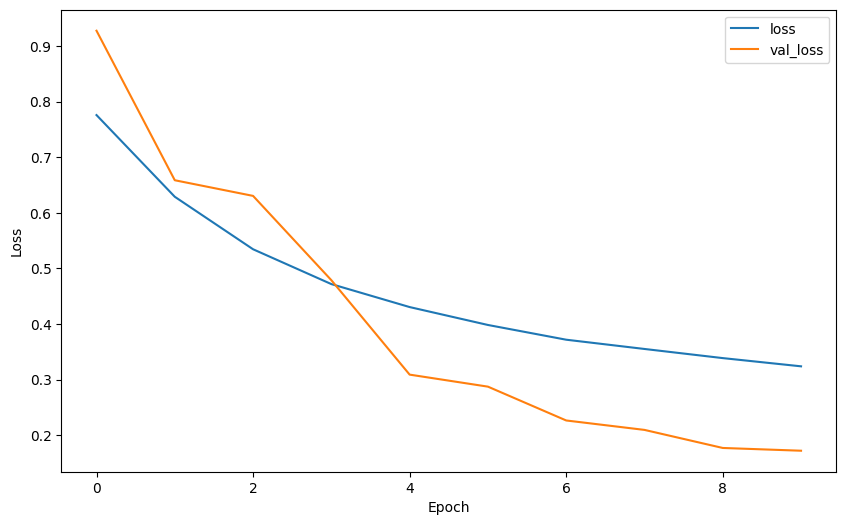

In [56]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

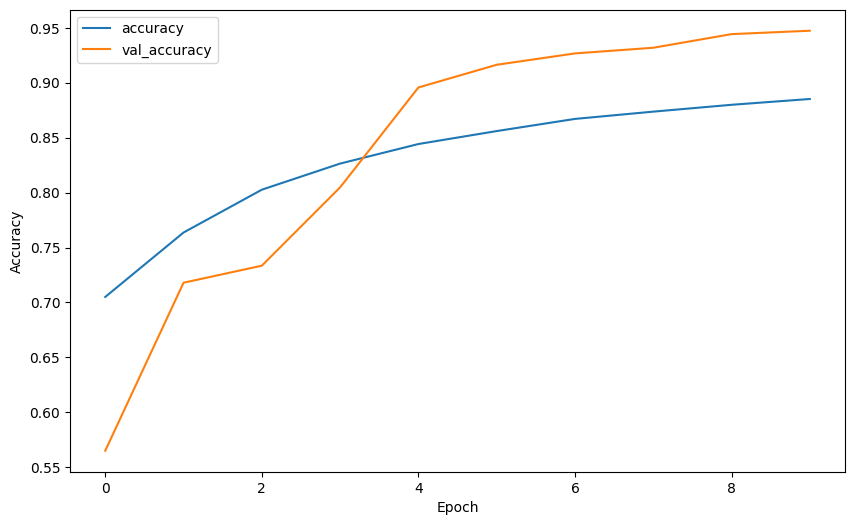

In [57]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [48]:
model.evaluate(test_image_gen)

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.9502 - loss: 0.1465


[0.17772744596004486, 0.94111567735672]

In [49]:
model.metrics_names

['loss', 'compile_metrics']

In [50]:
pred_probabilities = model.predict(test_image_gen)

 1/31 ━━━━━━━━━━━━━━━━━━━━ 18s 611ms/step

W0000 00:00:1718988307.769877     351 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step


In [51]:
pred_probabilities

array([[9.9972647e-01, 2.3176918e-07, 2.7321631e-04, 1.5405870e-09],
       [2.0412926e-01, 7.9551601e-01, 1.7371026e-04, 1.8104952e-04],
       [9.9997997e-01, 6.7130059e-06, 1.3214288e-05, 8.4698392e-08],
       ...,
       [4.6533090e-04, 1.2470520e-02, 1.4996382e-02, 9.7206777e-01],
       [5.6487283e-05, 3.0798200e-04, 4.7199279e-03, 9.9491560e-01],
       [4.2872527e-03, 2.8137669e-02, 5.7661608e-02, 9.0991336e-01]],
      dtype=float32)

In [52]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [53]:
predictions = pred_probabilities

In [54]:
predictions_argmax = np.argmax(predictions, axis=1)

print(classification_report(test_image_gen.classes, predictions_argmax))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       242
           1       0.97      0.91      0.94       242
           2       0.99      0.88      0.93       242
           3       0.93      0.99      0.96       242

    accuracy                           0.94       968
   macro avg       0.94      0.94      0.94       968
weighted avg       0.94      0.94      0.94       968



In [55]:
model.save('CNN_model1.h5')

# InceptionV3

In [14]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.20, # Shift the pic width by a max of 20%
                               height_shift_range=0.15, # Shift the pic height by a max of 15%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 15%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
batch_size = 32

In [19]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=True)

Found 83484 images belonging to 4 classes.


In [20]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 968 images belonging to 4 classes.


In [21]:
# Define input shape
input_shape = (299, 299, 1)  # Grayscale images with shape 299x299

# Create the input layer
inputs = Input(shape=input_shape)

# Convert grayscale to RGB by repeating the single channel across three channels
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

# Load the InceptionV3 model with ImageNet weights, without the top layers, and set the input tensor
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# Output layer
outputs = Dense(4, activation='softmax')(x)

# Create the model
InceptionV3_model = Model(inputs=inputs, outputs=outputs)

# Optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
InceptionV3_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Print the model summary
InceptionV3_model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 299, 299,  │          0 │ input_layer_3[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 149, 149,  │        864 │ concatenate_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 73, 73,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 89,063,268 (339.75 MB)

 Trainable params: 89,027,300 (339.61 MB)

 Non-trainable params: 35,968 (140.50 KB)

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience = 4)
checkpoint = ModelCheckpoint('InceptionV3_tuning.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')


In [25]:
InceptionV3_model_results = InceptionV3_model.fit(train_image_gen,epochs=10,
                    validation_data=test_image_gen,
                    callbacks=[early_stop, checkpoint])

Epoch 1/10


I0000 00:00:1718999704.318078     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8326 - loss: 0.5103
Epoch 1: val_loss improved from inf to 0.08105, saving model to InceptionV3_tuning.keras


W0000 00:00:1719001033.062248     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1442s 511ms/step - accuracy: 0.8327 - loss: 0.5102 - val_accuracy: 0.9762 - val_loss: 0.0810
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9445 - loss: 0.1676
Epoch 2: val_loss improved from 0.08105 to 0.07068, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 739s 282ms/step - accuracy: 0.9445 - loss: 0.1676 - val_accuracy: 0.9742 - val_loss: 0.0707
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9538 - loss: 0.1419
Epoch 3: val_loss improved from 0.07068 to 0.05925, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 740s 283ms/step - accuracy: 0.9538 - loss: 0.1419 - val_accuracy: 0.9814 - val_loss: 0.0593
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9580 - loss: 0.1285
Epoch 4: val_loss did not improve from 0.05925
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 737s 282ms/step - accuracy: 0.9580 - loss: 0.1285 - val_accuracy: 0.9711 - val_loss: 0.0714
Epoc

In [28]:
summary = pd.DataFrame(InceptionV3_model.history.history)
summary

,accuracy,loss,val_accuracy,val_loss
0,0.908545,0.281853,0.976240,0.081046
1,0.947271,0.160209,0.974174,0.070678
2,0.953716,0.141917,0.981405,0.059251
3,0.958735,0.125015,0.971074,0.071407
4,0.962927,0.112900,0.994835,0.016770
5,0.964748,0.105363,0.993802,0.030722
6,0.967527,0.095606,0.988636,0.036220
7,0.968844,0.091508,0.975207,0.068778
8,0.970342,0.087392,0.989669,0.028402


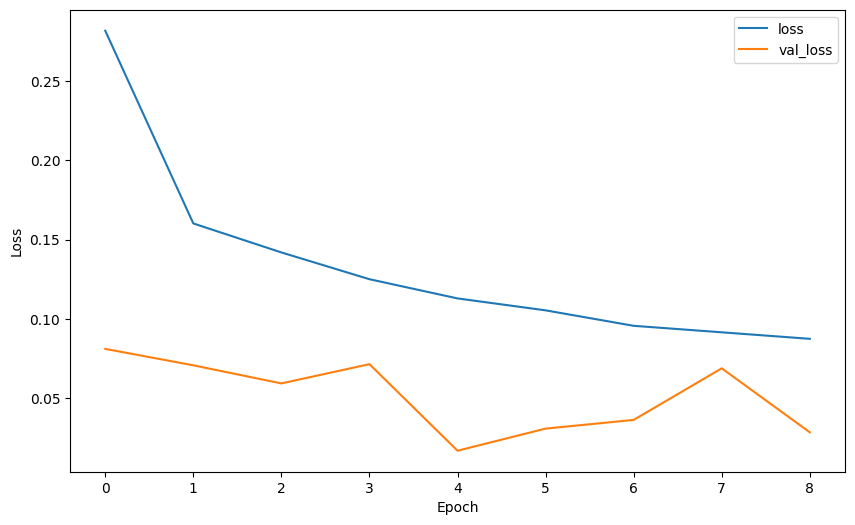

In [29]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

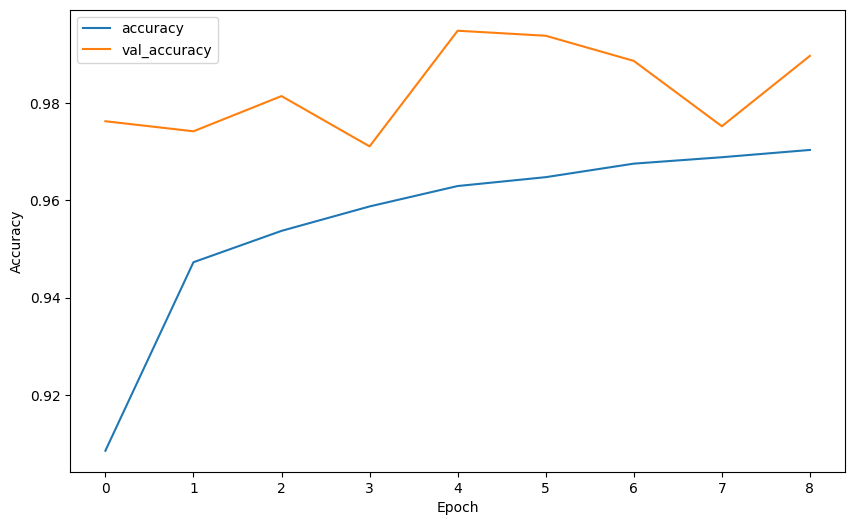

In [30]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [31]:
pred_probabilities = InceptionV3_model.predict(test_image_gen)

31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 412ms/step


W0000 00:00:1719007028.877132     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [32]:
predictions_argmax = np.argmax(pred_probabilities, axis=1)

print(classification_report(test_image_gen.classes, predictions_argmax))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       242
           1       1.00      1.00      1.00       242
           2       1.00      0.96      0.98       242
           3       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



[[242   0   0   0]
 [  0 242   0   0]
 [  9   0 233   0]
 [  1   0   0 241]]


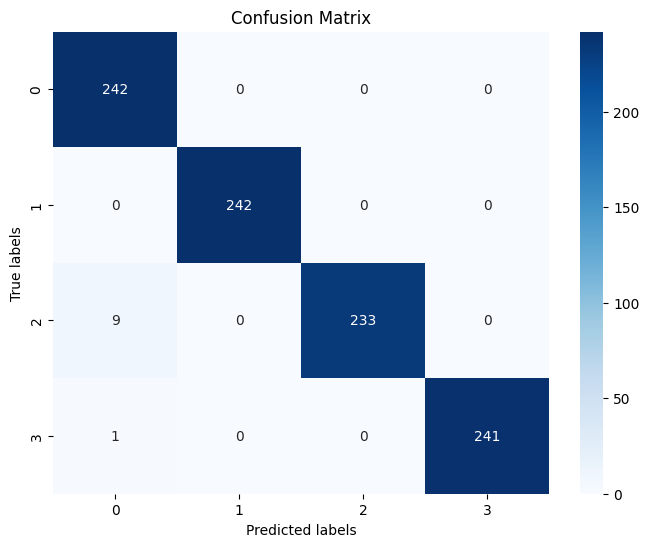

In [33]:
conf_matrix = confusion_matrix(test_image_gen.classes, predictions_argmax)
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# InceptionV3 Fine-Tuning Model

In [9]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.20, # Shift the pic width by a max of 20%
                               height_shift_range=0.15, # Shift the pic height by a max of 15%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 15%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
batch_size = 32

In [10]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=True)

Found 83484 images belonging to 4 classes.


In [12]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 968 images belonging to 4 classes.


In [16]:
# Define input shape
input_shape = (299, 299, 1)  # Grayscale images with shape 299x299

# Create the input layer
inputs = Input(shape=input_shape)

# Convert grayscale to RGB by repeating the single channel across three channels
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

# Load the InceptionV3 model with ImageNet weights, without the top layers, and set the input tensor
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Fully connected layers with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate

x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output layer
outputs = Dense(4, activation='softmax')(x)

# Create the model
InceptionV3_model = Model(inputs=inputs, outputs=outputs)

# Optimizer
optimizer = Adam(learning_rate=1e-5)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

checkpoint = ModelCheckpoint('InceptionV3_tuning.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')


# Compile the model
InceptionV3_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Print the model summary
InceptionV3_model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 299, 299,  │          0 │ input_layer_4[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 149, 149,  │        864 │ concatenate_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 73, 73,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 89,063,268 (339.75 MB)

 Trainable params: 89,027,300 (339.61 MB)

 Non-trainable params: 35,968 (140.50 KB)

In [17]:
InceptionV3_model_results = InceptionV3_model.fit(train_image_gen,epochs=20,
                    validation_data=test_image_gen,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/20


I0000 00:00:1719045329.395146     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6613 - loss: 15.0681

W0000 00:00:1719046770.268097     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 12.11606, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1559s 554ms/step - accuracy: 0.6613 - loss: 15.0677 - val_accuracy: 0.9525 - val_loss: 12.1161
Epoch 2/20
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8943 - loss: 11.3246
Epoch 2: val_loss improved from 12.11606 to 7.90203, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 823s 292ms/step - accuracy: 0.8943 - loss: 11.3242 - val_accuracy: 0.9835 - val_loss: 7.9020
Epoch 3/20
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9276 - loss: 7.1172
Epoch 3: val_loss improved from 7.90203 to 4.56033, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 725s 277ms/step - accuracy: 0.9276 - loss: 7.1169 - val_accuracy: 0.9866 - val_loss: 4.5603
Epoch 4/20
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9408 - loss: 4.1726
Epoch 4: val_loss improved from 4.56033 to 2.80121, saving model to InceptionV

In [22]:
summary = pd.DataFrame(InceptionV3_model.history.history)
summary

,accuracy,loss,val_accuracy,val_loss
0,0.774232,14.152224,0.952479,12.116060
1,0.905431,10.250244,0.983471,7.902030
2,0.932286,6.248142,0.986570,4.560327
3,0.942947,3.712572,0.988636,2.801214
4,0.952147,2.424144,0.977273,1.941491
5,0.955812,1.752373,0.990702,1.422303
6,0.959837,1.342921,0.992769,1.103024
7,0.963298,1.055615,0.985537,0.876479
8,0.966305,0.837478,0.989669,0.684355
9,0.968210,0.680038,0.990702,0.550501


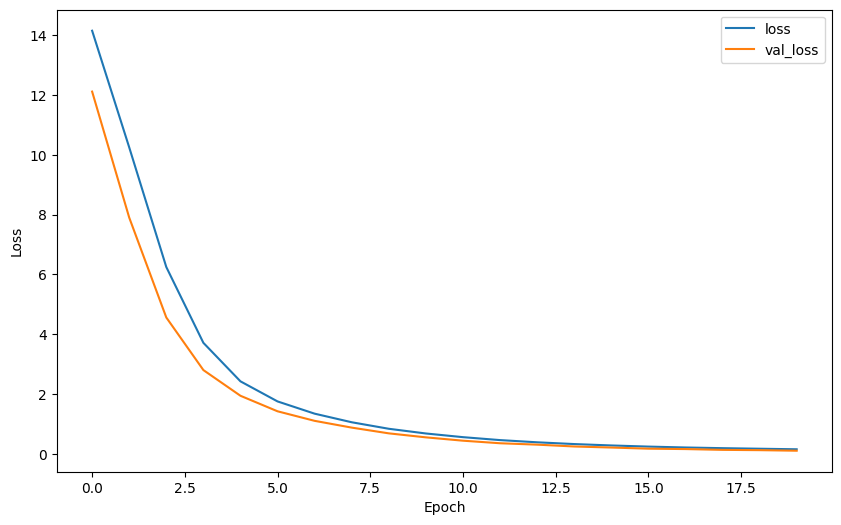

In [23]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

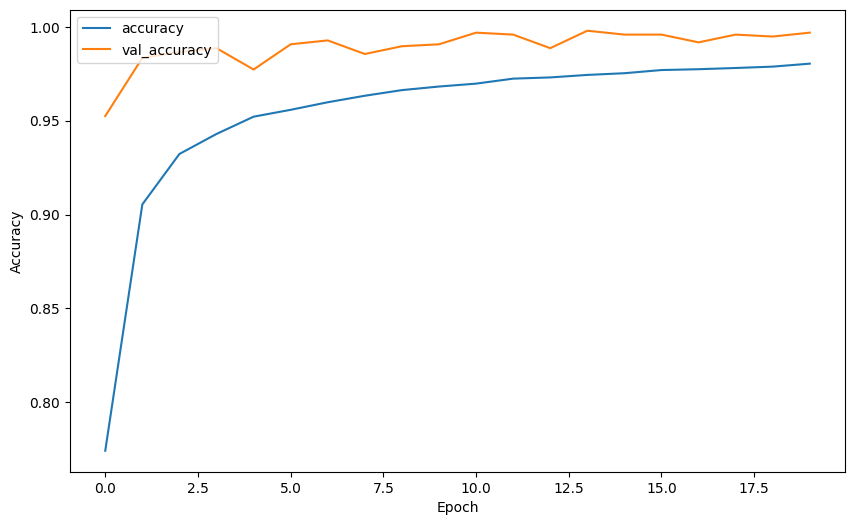

In [24]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [25]:
pred_probabilities = InceptionV3_model.predict(test_image_gen)

31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 419ms/step


W0000 00:00:1719061019.636487     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
predictions_argmax = np.argmax(pred_probabilities, axis=1)

print(classification_report(test_image_gen.classes, predictions_argmax))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       242
           1       1.00      1.00      1.00       242
           2       1.00      0.99      1.00       242
           3       1.00      1.00      1.00       242

    accuracy                           1.00       968
   macro avg       1.00      1.00      1.00       968
weighted avg       1.00      1.00      1.00       968



[[242   0   0   0]
 [  1 241   0   0]
 [  2   0 240   0]
 [  0   0   0 242]]


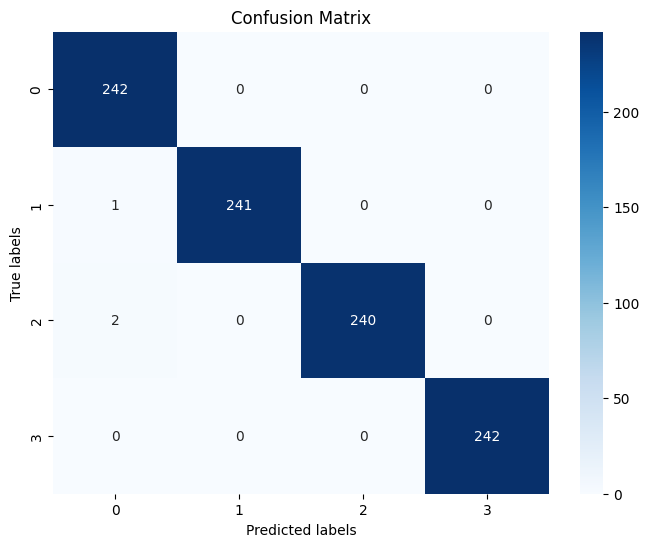

In [27]:
conf_matrix = confusion_matrix(test_image_gen.classes, predictions_argmax)
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#  Evaluating Model Performance on Unseen Validation Data


In [28]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = image_gen.flow_from_directory(val_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 32 images belonging to 4 classes.


In [30]:
val_gen.reset()
val_probabilities = InceptionV3_model.predict(val_gen)
val_predictions_argmax = np.argmax(val_probabilities, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


In [32]:
print(classification_report(val_gen.classes, val_predictions_argmax))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

